## 0. Setup

In [59]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from pathlib import Path
from torch import nn
from torchvision import transforms
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict
import pandas as pd
from torchvision import models
from pathlib import Path

# Custom imports
from going_modular.going_modular import data_setup, engine, utils
from helper_functions import download_data, set_seeds, plot_loss_curves

# Check PyTorch and TorchVision versions
try:
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except AssertionError as e:
    print(f"[INFO] {e} Updating PyTorch and TorchVision to required versions...")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"Updated torch version: {torch.__version__}")
    print(f"Updated torchvision version: {torchvision.__version__}")


[INFO] torch version should be 1.12+ Updating PyTorch and TorchVision to required versions...
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Updated torch version: 2.5.1+cpu
Updated torchvision version: 0.20.1+cpu


In [2]:
!ls going_modular/going_modular

README.md
__pycache__
data_setup.py
engine.py
model_builder.py
predictions.py
train.py
utils.py


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Getting Data

In [4]:
data_20_percent_path=Path("./data/pizza_steak_sushi_20_percent")
data_20_percent_path

WindowsPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

## 2. Creating an EffNetB2 feature extractor

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True))

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [9]:
def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

### 3.2 Creating DataLoaders for EffNetB2

In [11]:
# Setup DataLoaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [12]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [13]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9804 | train_acc: 0.5646 | test_loss: 0.7385 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.6843 | train_acc: 0.8729 | test_loss: 0.5931 | test_acc: 0.9347
Epoch: 3 | train_loss: 0.5644 | train_acc: 0.8979 | test_loss: 0.4820 | test_acc: 0.9347
Epoch: 4 | train_loss: 0.4720 | train_acc: 0.8667 | test_loss: 0.4185 | test_acc: 0.9443
Epoch: 5 | train_loss: 0.4309 | train_acc: 0.8729 | test_loss: 0.3725 | test_acc: 0.9568
Epoch: 6 | train_loss: 0.3748 | train_acc: 0.8938 | test_loss: 0.3456 | test_acc: 0.9443
Epoch: 7 | train_loss: 0.3367 | train_acc: 0.9083 | test_loss: 0.3123 | test_acc: 0.9506
Epoch: 8 | train_loss: 0.3237 | train_acc: 0.9250 | test_loss: 0.3014 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.3657 | train_acc: 0.8625 | test_loss: 0.2753 | test_acc: 0.9381
Epoch: 10 | train_loss: 0.2551 | train_acc: 0.9437 | test_loss: 0.2639 | test_acc: 0.9597


### 3.4 Inspecting EffNetB2 loss curves

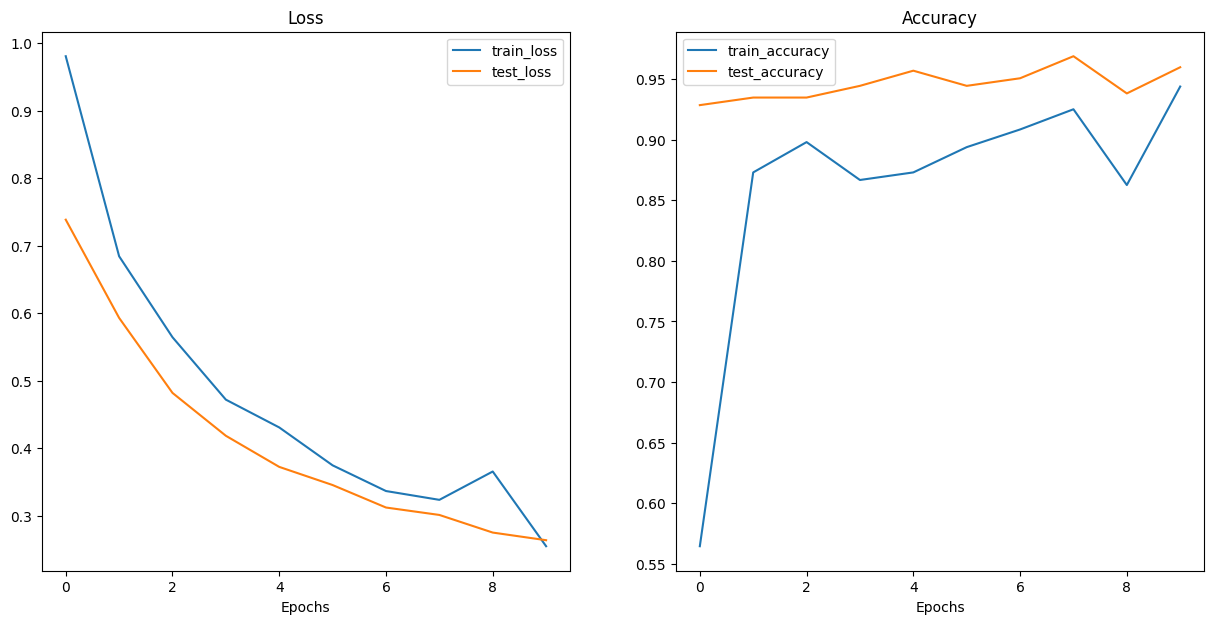

In [14]:
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [15]:
# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

In [16]:
# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [17]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [18]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.263948580622673,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.85711097717285}

## 4. Creating a ViT feature extractor

In [19]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                        out_features=num_classes))

  return model, transforms

In [21]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 4.1 Create DataLoaders for ViT feature extractor

In [22]:
# Setup ViT DataLoaders
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### 4.2 Training ViT Feature Extractor

In [23]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

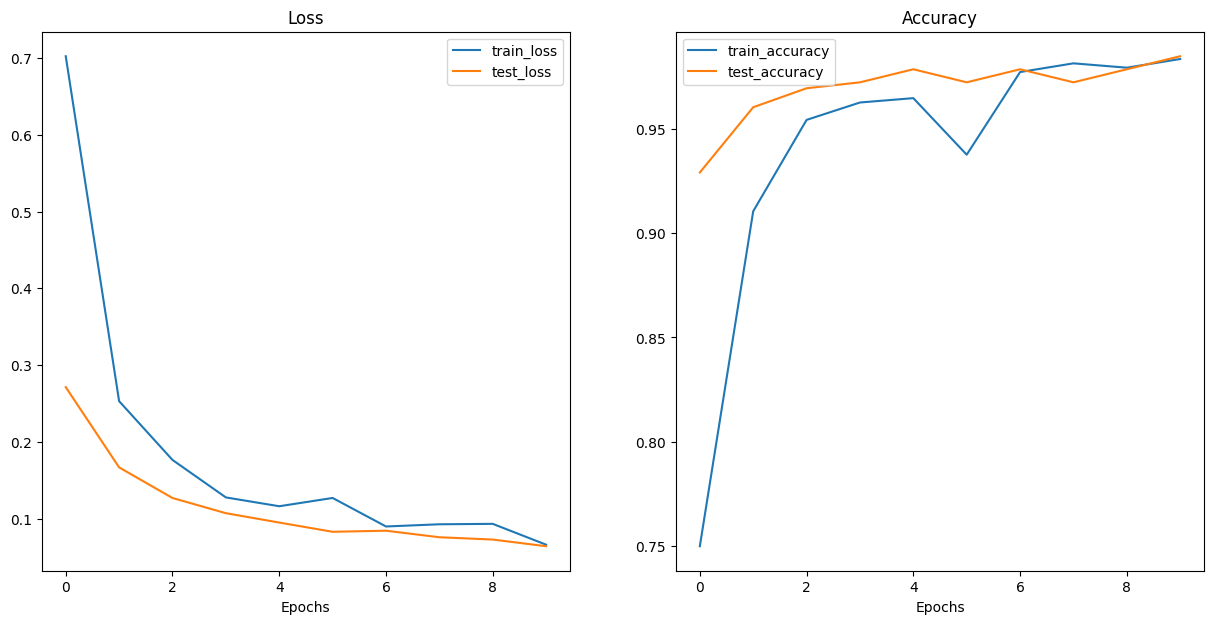

In [24]:
plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [25]:
# Save model
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [26]:
# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327.3689556121826 MB


### 4.6 Collecting ViT feature extractor stats

In [27]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [28]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06418204284273088,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3689556121826}

## 5. Creating a ResNet feature extractor

In [29]:
# Check out the ResNet heads layer
resnet = torchvision.models.resnet50()
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [30]:
def create_resnet_model(num_classes:int=3,
                     seed:int=42):
  # Create ResNet50_Weights pretrained weights, transforms and model
  weights = torchvision.models.ResNet50_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.resnet50(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier fc to suit our needs
  torch.manual_seed(seed)
  model.fc = nn.Sequential(nn.Linear(in_features=2048,
                                        out_features=num_classes))

  return model, transforms

In [31]:
resnet, resnet_transforms = create_resnet_model()
resnet_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 5.1 Create DataLoaders for ResNet feature extractor

In [32]:
# Setup ResNet DataLoaders
train_dataloader_resnet, test_dataloader_resnet, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=resnet_transforms,
                                                                                       batch_size=32)

### 5.2 Training ResNet Feature Extractor

In [33]:
# Setup optimizer
optimizer = torch.optim.Adam(params=resnet.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ResNet feature extractor with seeds set for reproducibility
set_seeds()
resnet_results = engine.train(model=resnet,
                           train_dataloader=train_dataloader_resnet,
                           test_dataloader=test_dataloader_resnet,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9950 | train_acc: 0.5437 | test_loss: 0.7962 | test_acc: 0.8920
Epoch: 2 | train_loss: 0.7088 | train_acc: 0.8646 | test_loss: 0.6720 | test_acc: 0.9381
Epoch: 3 | train_loss: 0.5804 | train_acc: 0.8729 | test_loss: 0.5764 | test_acc: 0.9131
Epoch: 4 | train_loss: 0.4598 | train_acc: 0.9333 | test_loss: 0.5361 | test_acc: 0.9347
Epoch: 5 | train_loss: 0.4154 | train_acc: 0.9167 | test_loss: 0.4568 | test_acc: 0.9227
Epoch: 6 | train_loss: 0.3939 | train_acc: 0.8812 | test_loss: 0.4153 | test_acc: 0.9381
Epoch: 7 | train_loss: 0.3832 | train_acc: 0.9042 | test_loss: 0.3882 | test_acc: 0.9222
Epoch: 8 | train_loss: 0.4046 | train_acc: 0.8833 | test_loss: 0.3971 | test_acc: 0.9165
Epoch: 9 | train_loss: 0.2966 | train_acc: 0.9375 | test_loss: 0.3772 | test_acc: 0.9068
Epoch: 10 | train_loss: 0.3075 | train_acc: 0.9271 | test_loss: 0.3690 | test_acc: 0.9472


### 5.3 Plot loss curves of ResNet feature extractor

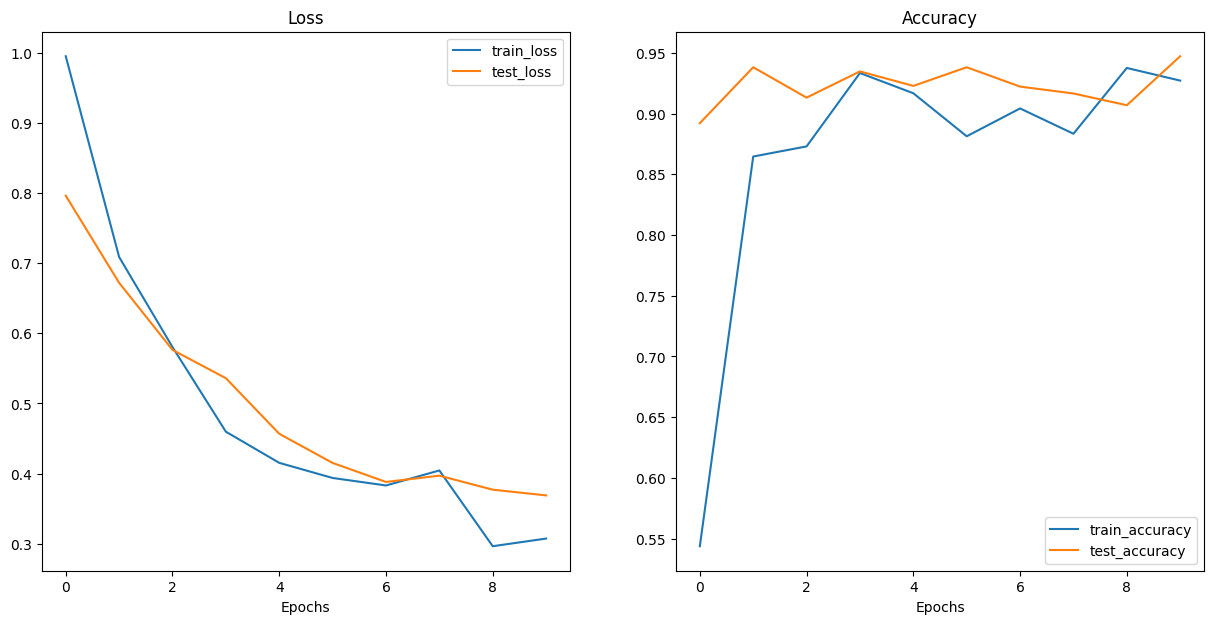

In [34]:
plot_loss_curves(resnet_results)

### 5.4 Saving ResNet feature extractor

In [35]:
# Save model
utils.save_model(model=resnet,
                 target_dir="models",
                 model_name="09_pretrained_resnet_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_resnet_feature_extractor_pizza_steak_sushi_20_percent.pth


### 5.5 Checking the size of ResNet feature extractor

In [36]:
# Get the model size in bytes then convert to megabytes
pretrained_resnet_model_size = Path("models/09_pretrained_resnet_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained ResNet feature extractor model size: {pretrained_resnet_model_size} MB")

Pretrained ResNet feature extractor model size: 90.02017402648926 MB


### 5.6 Collecting ResNet feature extractor stats

In [37]:
# Count number of parameters in ResNet
resnet_total_params = sum(torch.numel(param) for param in resnet.parameters())
resnet_total_params

23514179

In [38]:
# Create ResNet statistics dictionary
resnet_stats = {"test_loss": resnet_results["test_loss"][-1],
             "test_acc": resnet_results["test_acc"][-1],
             "number_of_parameters": resnet_total_params,
             "model_size (MB)": pretrained_resnet_model_size}

resnet_stats

{'test_loss': 0.3690232992172241,
 'test_acc': 0.947159090909091,
 'number_of_parameters': 23514179,
 'model_size (MB)': 90.02017402648926}

## 6. Creating a SwinTransformer feature extractor

In [39]:
# Check out the SwinTransformer heads layer
swinT = torchvision.models.swin_t()
swinT.head

Linear(in_features=768, out_features=1000, bias=True)

In [40]:
def create_SwinT_model(num_classes:int=3,
                     seed:int=42):
  # Create SwinTransformer pretrained weights, transforms and model
  weights = torchvision.models.Swin_T_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.swin_t(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier fc to suit our needs
  torch.manual_seed(seed)
  model.head =nn.Sequential(
                    nn.Linear(in_features=768, out_features=512),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(in_features=512, out_features=num_classes)
                )
  return model, transforms

In [41]:
swinT, swinT_transforms = create_SwinT_model()
swinT_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 6.1 Create DataLoaders for SwinTransformer feature extractor

In [42]:
# Setup SwinTransformer DataLoaders
train_dataloader_swinT, test_dataloader_swinT, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=swinT_transforms,
                                                                                       batch_size=32)

### 6.2 Training SwinTransformer Feature Extractor

In [43]:
# Setup optimizer
optimizer = torch.optim.Adam(params=swinT.parameters(),
                             lr=1e-4)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train SwinTransformer feature extractor with seeds set for reproducibility
set_seeds()
swinT_results = engine.train(model=swinT,
                           train_dataloader=train_dataloader_swinT,
                           test_dataloader=test_dataloader_swinT,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9527 | train_acc: 0.6646 | test_loss: 0.6859 | test_acc: 0.9693
Epoch: 2 | train_loss: 0.6427 | train_acc: 0.9396 | test_loss: 0.4523 | test_acc: 0.9693
Epoch: 3 | train_loss: 0.4480 | train_acc: 0.9396 | test_loss: 0.3022 | test_acc: 0.9847
Epoch: 4 | train_loss: 0.3245 | train_acc: 0.9563 | test_loss: 0.2151 | test_acc: 0.9847
Epoch: 5 | train_loss: 0.2541 | train_acc: 0.9583 | test_loss: 0.1647 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.2098 | train_acc: 0.9646 | test_loss: 0.1330 | test_acc: 0.9784
Epoch: 7 | train_loss: 0.1667 | train_acc: 0.9604 | test_loss: 0.1137 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.1692 | train_acc: 0.9583 | test_loss: 0.0973 | test_acc: 0.9847
Epoch: 9 | train_loss: 0.1506 | train_acc: 0.9625 | test_loss: 0.0857 | test_acc: 0.9938
Epoch: 10 | train_loss: 0.1388 | train_acc: 0.9646 | test_loss: 0.0804 | test_acc: 0.9938


### 6.3 Plot loss curves of SwinTransformer feature extractor

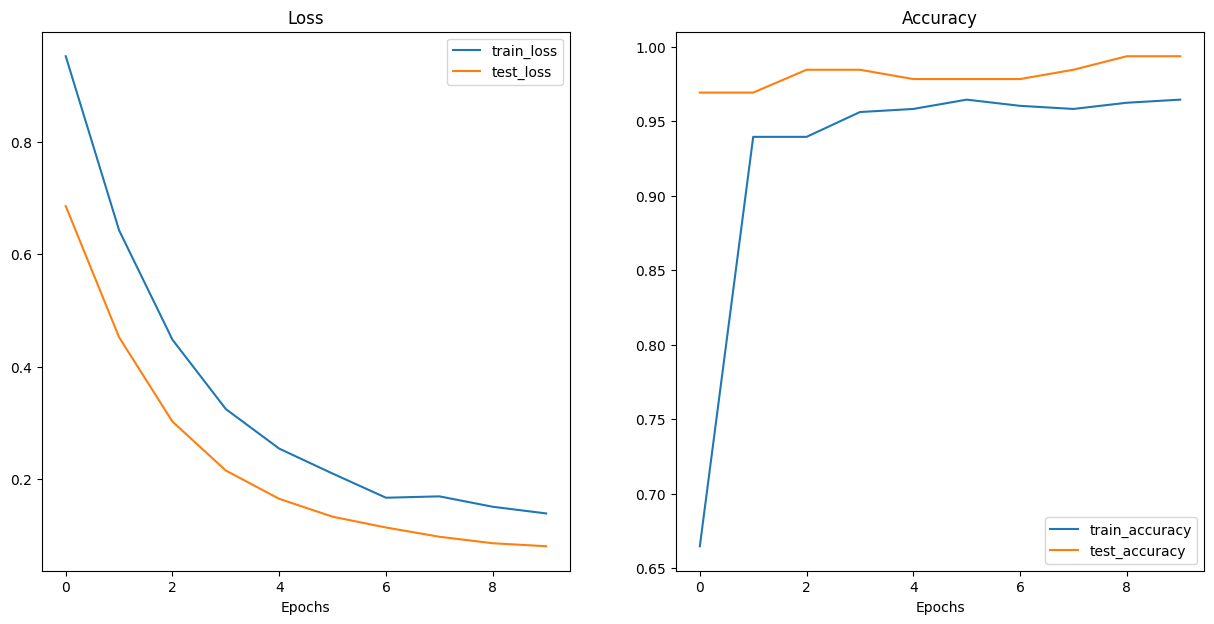

In [44]:
plot_loss_curves(swinT_results)

### 6.4 Saving SwinTransformer feature extractor

In [45]:
# Save model
utils.save_model(model=swinT,
                 target_dir="models",
                 model_name="09_pretrained_swinT_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\09_pretrained_swinT_feature_extractor_pizza_steak_sushi_20_percent.pth


### 6.5 Checking the size of SwinTransformer feature extractor

In [46]:
# Get the model size in bytes then convert to megabytes
pretrained_swinT_model_size = Path("models/09_pretrained_swinT_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained SWinTransformer feature extractor model size: {pretrained_swinT_model_size} MB")

Pretrained SWinTransformer feature extractor model size: 106.77887058258057 MB


### 6.6 Collecting SwinTransformer feature extractor stats

In [47]:
# Count number of parameters in ResNet
swinT_total_params = sum(torch.numel(param) for param in swinT.parameters())
swinT_total_params

27914621

In [48]:
# Create SwinTransformer statistics dictionary
swinT_stats = {"test_loss": swinT_results["test_loss"][-1],
             "test_acc": swinT_results["test_acc"][-1],
             "number_of_parameters": swinT_total_params,
             "model_size (MB)": pretrained_swinT_model_size}
swinT_stats

{'test_loss': 0.08040418662130833,
 'test_acc': 0.99375,
 'number_of_parameters': 27914621,
 'model_size (MB)': 106.77887058258057}

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0439 | train_acc: 0.4729 | test_loss: 0.8006 | test_acc: 0.7528
Epoch: 2 | train_loss: 0.7559 | train_acc: 0.7167 | test_loss: 0.6727 | test_acc: 0.7562
Epoch: 3 | train_loss: 0.5984 | train_acc: 0.8167 | test_loss: 0.4927 | test_acc: 0.9284
Epoch: 4 | train_loss: 0.4551 | train_acc: 0.9021 | test_loss: 0.4475 | test_acc: 0.8648
Epoch: 5 | train_loss: 0.4274 | train_acc: 0.8750 | test_loss: 0.4205 | test_acc: 0.8938
Epoch: 6 | train_loss: 0.4921 | train_acc: 0.8354 | test_loss: 0.3470 | test_acc: 0.9199
Epoch: 7 | train_loss: 0.4007 | train_acc: 0.8833 | test_loss: 0.3372 | test_acc: 0.8983
Epoch: 8 | train_loss: 0.4170 | train_acc: 0.8583 | test_loss: 0.2767 | test_acc: 0.9409
Epoch: 9 | train_loss: 0.3668 | train_acc: 0.8771 | test_loss: 0.2892 | test_acc: 0.9500
Epoch: 10 | train_loss: 0.4318 | train_acc: 0.8396 | test_loss: 0.2615 | test_acc: 0.9256
[INFO] Saving model to: models\densenet121_feature_extractor.pth
DenseNet model size: 27.12 MB


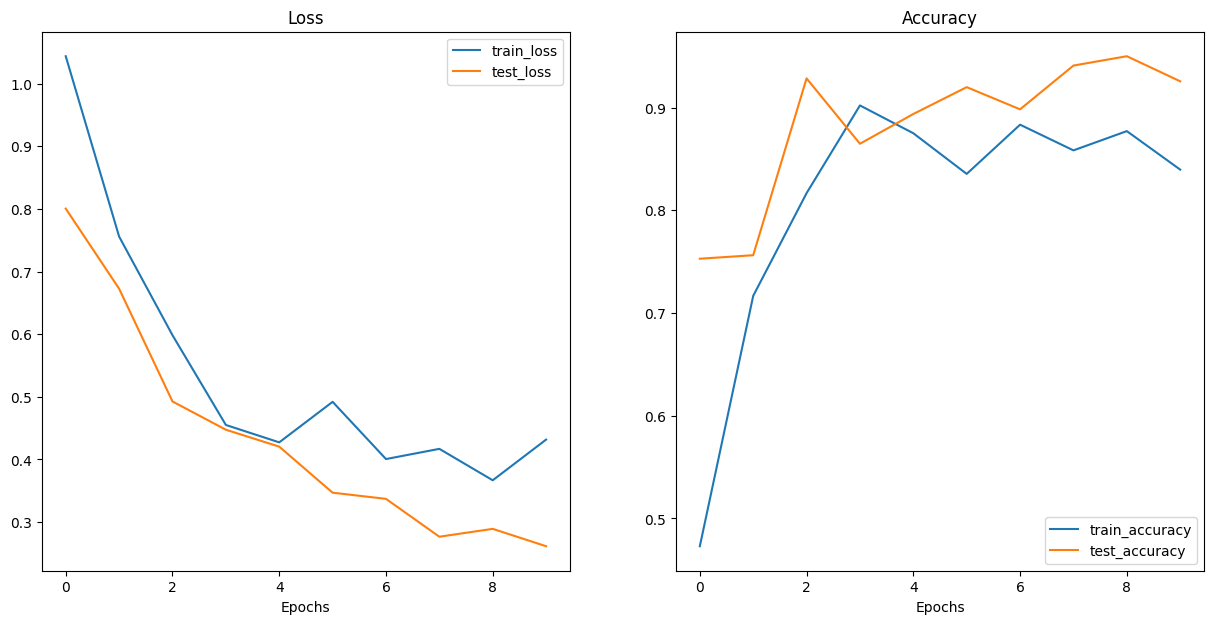

In [51]:
def create_densenet_model(num_classes: int = 3, seed: int = 42):
    """
    Create a DenseNet model pre-trained on ImageNet with a modified classifier head.
    """

    # Load pre-trained DenseNet with default weights
    weights = models.DenseNet121_Weights.DEFAULT  # Using DenseNet121
    transforms = weights.transforms()
    model = models.densenet121(weights=weights)

    # Freeze all of the base layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the classifier for the desired number of classes
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
    )

    return model, transforms

# Create DenseNet model and transforms
densenet, densenet_transforms = create_densenet_model()

# Setup DenseNet DataLoaders
train_dataloader_densenet, test_dataloader_densenet, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=densenet_transforms,
    batch_size=32,
)

# Setup optimizer and loss function
optimizer = torch.optim.Adam(params=densenet.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train DenseNet feature extractor
set_seeds()
densenet_results = engine.train(
    model=densenet,
    train_dataloader=train_dataloader_densenet,
    test_dataloader=test_dataloader_densenet,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
)

plot_loss_curves(densenet_results)

utils.save_model(
    model=densenet,
    target_dir="models",
    model_name="densenet121_feature_extractor.pth",
)

# Check model size
pretrained_densenet_model_size = Path("models/densenet121_feature_extractor.pth").stat().st_size / (1024 * 1024)
print(f"DenseNet model size: {pretrained_densenet_model_size:.2f} MB")

In [52]:
# Count number of parameters in DenseNet
dense_total_params = sum(torch.numel(param) for param in densenet.parameters())
dense_total_params

6956931

In [53]:
# Create DenseNet statistics dictionary
dense_stats = {"test_loss": densenet_results["test_loss"][-1],
             "test_acc": densenet_results["test_acc"][-1],
             "number_of_parameters": dense_total_params,
             "model_size (MB)": pretrained_densenet_model_size}
dense_stats

{'test_loss': 0.261532661318779,
 'test_acc': 0.9255681818181818,
 'number_of_parameters': 6956931,
 'model_size (MB)': 27.12093162536621}

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4742 | train_acc: 0.6687 | test_loss: 1.0483 | test_acc: 0.7812
Epoch: 2 | train_loss: 0.4728 | train_acc: 0.8854 | test_loss: 0.3516 | test_acc: 0.9187
Epoch: 3 | train_loss: 0.2590 | train_acc: 0.9542 | test_loss: 0.1734 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1150 | train_acc: 0.9750 | test_loss: 2.3003 | test_acc: 0.8063
Epoch: 5 | train_loss: 0.3496 | train_acc: 0.9479 | test_loss: 1.3635 | test_acc: 0.9097
Epoch: 6 | train_loss: 0.4407 | train_acc: 0.9667 | test_loss: 1.2017 | test_acc: 0.9318
Epoch: 7 | train_loss: 0.2941 | train_acc: 0.9729 | test_loss: 0.8495 | test_acc: 0.9506
Epoch: 8 | train_loss: 0.2118 | train_acc: 0.9812 | test_loss: 0.7922 | test_acc: 0.9568
Epoch: 9 | train_loss: 0.1470 | train_acc: 0.9875 | test_loss: 1.1717 | test_acc: 0.9347
Epoch: 10 | train_loss: 0.1414 | train_acc: 0.9896 | test_loss: 1.2157 | test_acc: 0.9506
[INFO] Saving model to: models\vgg16_feature_extractor.pth
VGG model size: 512.22 MB


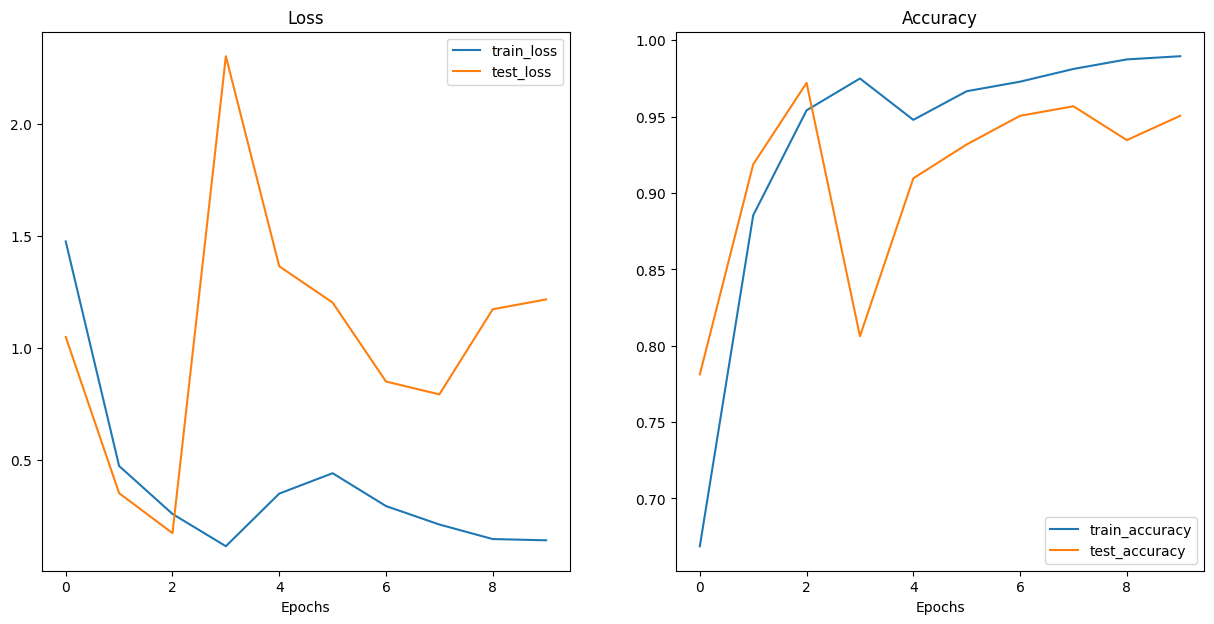

In [54]:
def create_vgg_model(num_classes: int = 3, seed: int = 42):
    """
    Create a VGG model pre-trained on ImageNet with a modified classifier head.
    """
    # Load pre-trained VGG16 with default weights
    weights = models.VGG16_Weights.DEFAULT  # Using VGG16
    transforms = weights.transforms()
    model = models.vgg16(weights=weights)

    # Freeze all of the base layers (only the convolutional layers)
    for param in model.features.parameters():
        param.requires_grad = False

    # Modify the classifier for the desired number of classes
    torch.manual_seed(seed)
    model.classifier[-1] = nn.Linear(
        in_features=model.classifier[-1].in_features, out_features=num_classes
    )

    return model, transforms

# Create VGG model and transforms
vgg, vgg_transforms = create_vgg_model()

# Setup VGG DataLoaders
train_dataloader_vgg, test_dataloader_vgg, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vgg_transforms,
    batch_size=32,
)

# Setup optimizer and loss function
optimizer = torch.optim.Adam(params=vgg.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train VGG feature extractor
set_seeds()
vgg_results = engine.train(
    model=vgg,
    train_dataloader=train_dataloader_vgg,
    test_dataloader=test_dataloader_vgg,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
)

# Plot VGG loss curves
plot_loss_curves(vgg_results)

# Save VGG model
utils.save_model(
    model=vgg,
    target_dir="models",
    model_name="vgg16_feature_extractor.pth",
)

# Check model size
pretrained_vgg_model_size = Path("models/vgg16_feature_extractor.pth").stat().st_size / (1024 * 1024)
print(f"VGG model size: {pretrained_vgg_model_size:.2f} MB")

In [55]:
# Count number of parameters in ResNet
vgg_total_params = sum(torch.numel(param) for param in vgg.parameters())
vgg_total_params

134272835

In [56]:
# Create SwinTransformer statistics dictionary
vgg_stats = {"test_loss": vgg_results["test_loss"][-1],
             "test_acc": vgg_results["test_acc"][-1],
             "number_of_parameters": vgg_total_params,
             "model_size (MB)": pretrained_vgg_model_size}
vgg_stats

{'test_loss': 1.2157408557341114,
 'test_acc': 0.9505681818181818,
 'number_of_parameters': 134272835,
 'model_size (MB)': 512.2214870452881}

In [57]:
# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [66]:
# 1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(paths: List[Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2. Create an empty list (can return a full list of all predictions later).
  pred_list = []

  # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer.
    start_time = timer()

    # 7. Open the image using Image.open(path)
    img = Image.open(path)

    # 8. Transform the image to be usable with a given model (also add a batch dimension and send to target device)
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model model for inference by sending to the target device and turning on eval() mode.
    model = model.to(device)
    model.eval()

    # 10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into predicition probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probability into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

      # 11. Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # 13. See if the predicted class matches the ground truth class.
    pred_dict["correct"] = class_name == pred_class

    # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
    pred_list.append(pred_dict)

  # 15. Return the list of prediction dictionaries.
  return pred_list

In [67]:
# Define models, transforms, and their names in a list
models = [
    {"name": "EffNetB2", "model": effnetb2, "transform": effnetb2_transforms},
    {"name": "ViT", "model": vit, "transform": vit_transforms},
    {"name": "ResNet", "model": resnet, "transform": resnet_transforms},
    {"name": "SwinT", "model": swinT, "transform": swinT_transforms},
    {"name": "DenseNet", "model": densenet, "transform": densenet_transforms},
    {"name": "VGG", "model": vgg, "transform": vgg_transforms},
]

# Dictionary to store test predictions
test_pred_dicts = {}

# Iterate through each model and generate predictions
for model_info in models:
    name = model_info["name"]
    model = model_info["model"]
    transform = model_info["transform"]
    
    print(f"Making predictions with {name}...")
    
    # Store predictions in the dictionary
    test_pred_dicts[name] = pred_and_store(
        paths=test_data_paths,
        model=model,
        transform=transform,
        class_names=class_names,
        device="cpu",  # Hardcode to CPU
    )

Making predictions with EffNetB2...


  0%|          | 0/150 [00:00<?, ?it/s]

Making predictions with ViT...


  0%|          | 0/150 [00:00<?, ?it/s]

Making predictions with ResNet...


  0%|          | 0/150 [00:00<?, ?it/s]

Making predictions with SwinT...


  0%|          | 0/150 [00:00<?, ?it/s]

Making predictions with DenseNet...


  0%|          | 0/150 [00:00<?, ?it/s]

Making predictions with VGG...


  0%|          | 0/150 [00:00<?, ?it/s]

In [68]:
# Access predictions from the test_pred_dicts dictionary
effnetb2_test_pred_df = pd.DataFrame(test_pred_dicts["EffNetB2"])
vit_test_pred_df = pd.DataFrame(test_pred_dicts["ViT"])
resnet_test_pred_df = pd.DataFrame(test_pred_dicts["ResNet"])
swinT_test_pred_df = pd.DataFrame(test_pred_dicts["SwinT"])
denseNet_test_pred_df = pd.DataFrame(test_pred_dicts["DenseNet"])
vgg_test_pred_df = pd.DataFrame(test_pred_dicts["VGG"])

# An example of viewing the ResNet test predictions
print(resnet_test_pred_df.head())

                                          image_path class_name  pred_prob  \
0  data\pizza_steak_sushi_20_percent\test\pizza\1...      pizza     0.9574   
1  data\pizza_steak_sushi_20_percent\test\pizza\1...      pizza     0.4479   
2  data\pizza_steak_sushi_20_percent\test\pizza\1...      pizza     0.7491   
3  data\pizza_steak_sushi_20_percent\test\pizza\1...      pizza     0.8633   
4  data\pizza_steak_sushi_20_percent\test\pizza\1...      pizza     0.8824   

  pred_class  time_for_pred  correct  
0      pizza         0.2622     True  
1      pizza         0.0813     True  
2      pizza         0.0735     True  
3      pizza         0.0743     True  
4      pizza         0.0760     True  


### Comparison of Prediction Accuracy Across Models

In [69]:
# Combine all model results into a dictionary
results_dict = {
    "Model": ["EffNetB2", "ViT", "ResNet", "SwinTransformer", "DenseNet", "VGG"],
    "Correct": [
        effnetb2_test_pred_df.correct.value_counts().get(True, 0),
        vit_test_pred_df.correct.value_counts().get(True, 0),
        resnet_test_pred_df.correct.value_counts().get(True, 0),
        swinT_test_pred_df.correct.value_counts().get(True, 0),
        denseNet_test_pred_df.correct.value_counts().get(True, 0),
        vgg_test_pred_df.correct.value_counts().get(True, 0),
    ],
    "Incorrect": [
        effnetb2_test_pred_df.correct.value_counts().get(False, 0),
        vit_test_pred_df.correct.value_counts().get(False, 0),
        resnet_test_pred_df.correct.value_counts().get(False, 0),
        swinT_test_pred_df.correct.value_counts().get(False, 0),
        denseNet_test_pred_df.correct.value_counts().get(False, 0),
        vgg_test_pred_df.correct.value_counts().get(False, 0),
    ]
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Print the DataFrame
print(results_df)

             Model  Correct  Incorrect
0         EffNetB2      144          6
1              ViT      148          2
2           ResNet      142          8
3  SwinTransformer      149          1
4         DenseNet      139         11
5              VGG      143          7


### Calculate and Display Average Prediction Time for Models

In [72]:
# Compute average time per prediction for each model
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
resnet_average_time_per_pred = round(resnet_test_pred_df.time_for_pred.mean(), 4)
swinT_average_time_per_pred = round(swinT_test_pred_df.time_for_pred.mean(), 4)
denseNet_average_time_per_pred = round(denseNet_test_pred_df.time_for_pred.mean(), 4)
vgg_average_time_per_pred = round(vgg_test_pred_df.time_for_pred.mean(), 4)

# Combine all model times into a dictionary
average_time_dict = {
    "Model": ["EffNetB2", "ViT", "ResNet", "SwinTransformer", "DenseNet", "VGG"],
    "Average Time Per Prediction (s)": [
        effnetb2_average_time_per_pred,
        vit_average_time_per_pred,
        resnet_average_time_per_pred,
        swinT_average_time_per_pred,
        denseNet_average_time_per_pred,
        vgg_average_time_per_pred,
    ]
}

# Create a DataFrame from the dictionary
time_results_df = pd.DataFrame(average_time_dict)

# Print the DataFrame
print(time_results_df)

             Model  Average Time Per Prediction (s)
0         EffNetB2                           0.0689
1              ViT                           0.2382
2           ResNet                           0.0757
3  SwinTransformer                           0.0873
4         DenseNet                           0.0847
5              VGG                           0.1730


## Model Evaluation: Accuracy and Prediction Time Analysis

In [73]:
# Add time per pred to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
resnet_stats["time_per_pred_cpu"] = resnet_average_time_per_pred
swinT_stats["time_per_pred_cpu"] = swinT_average_time_per_pred
dense_stats["time_per_pred_cpu"] = denseNet_average_time_per_pred
vgg_stats["time_per_pred_cpu"] = vgg_average_time_per_pred

# Example of effnet stats
effnetb2_stats

{'test_loss': 0.263948580622673,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.85711097717285,
 'time_per_pred_cpu': 0.0689}

In [74]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats, resnet_stats, swinT_stats, dense_stats, vgg_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT", "ResNet", "SwinTransformer", "DenseNet", "VGG"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.263949,95.97,7705221,29.857111,0.0689,EffNetB2
1,0.064182,98.47,85800963,327.368956,0.2382,ViT
2,0.369023,94.72,23514179,90.020174,0.0757,ResNet
3,0.080404,99.38,27914621,106.778871,0.0873,SwinTransformer
4,0.261533,92.56,6956931,27.120932,0.0847,DenseNet
5,1.215741,95.06,134272835,512.221487,0.1730,VGG
